<h1 style='color:blue;'> MCMC 101 <br/>
how to fit a line in the real world <br/>
for more info see: http://dan.iel.fm/emcee/current/user/line/ </h1>

In [1]:
import sys
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as pl

In [2]:
sys.path.insert(2, '//project/projectdirs/lux/Tools/emcee')
sys.path.insert(2, '//project/projectdirs/lux/Tools/triangle')
import emcee
import triangle

In [3]:
%pylab inline  
#always do this for plotting...  don't ask why
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1>Make a toy data set with input truth values. Fit with linear regression as step 1 </h1>

In [14]:
# Generate some fake data. Choose the real "true" parameters.
m_true = -0.9594
b_true = 4.294

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
xerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += yerr * np.random.randn(N)
x += xerr * np.random.randn(N)

#fit with linear regression as the first guess
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# when fitting real data you will assume the true value is the result of the initial linregress(x,y) fit
m_guess = slope
b_guess = intercept


<h1> Setup maximum likelihood estimation </h1>

In [15]:
def lnlike(theta, x, y, xerr, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + (m*xerr)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

#fit around 4 times the mean value of the initial guess... this corresponds to 300% error :) ... plenty
def lnprior(theta, m_guess, b_guess):
    m, b = theta
    if (m_guess-abs(m_guess*3)) < m < (m_guess+abs(m_guess*3)) and (b_guess-abs(b_guess*3)) < b < (b_guess+abs(b_guess*3)):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, xerr, yerr, m_guess, b_guess):
    lp = lnprior(theta, m_guess, b_guess)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, xerr, yerr)

<h1>The Monte Carlo part <br/>
start 2 random walkers each taking 500 steps, 500 times. (one for each variable) </h1>

In [16]:
nll = lambda *args: -lnlike(*args)
result = scipy.optimize.minimize(nll, [m_guess, b_guess], args=(x, y, xerr, yerr))
m_ml, b_ml = result["x"]

ndim, nwalkers = 2, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, xerr, yerr, m_guess, b_guess))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

<h3> plot the results of the random walkers. see the values they tendend to move to, given the initial guess </h3>

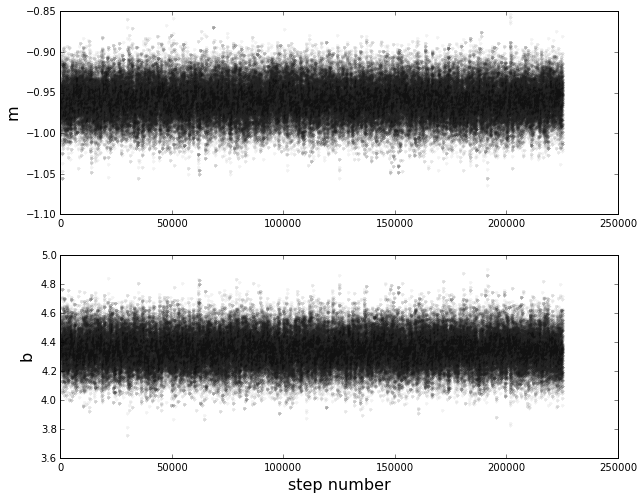

In [17]:
plt.subplot(2, 1, 1)
plt.plot(samples[:,0],'.k',alpha=0.05)
plt.ylabel('m',fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(samples[:,1],'.k',alpha=0.05)
plt.ylabel('b',fontsize=16)
plt.xlabel('step number',fontsize=16)

<h1> Make a traingle plot to view the errors and the correlation </h1>

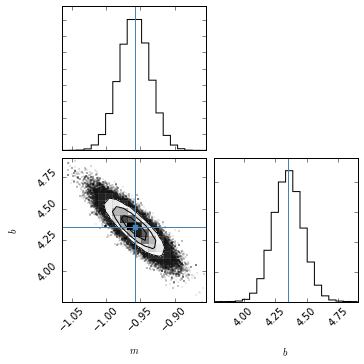

In [18]:
fig = triangle.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_ml, b_ml])
fig.savefig("triangle.png")

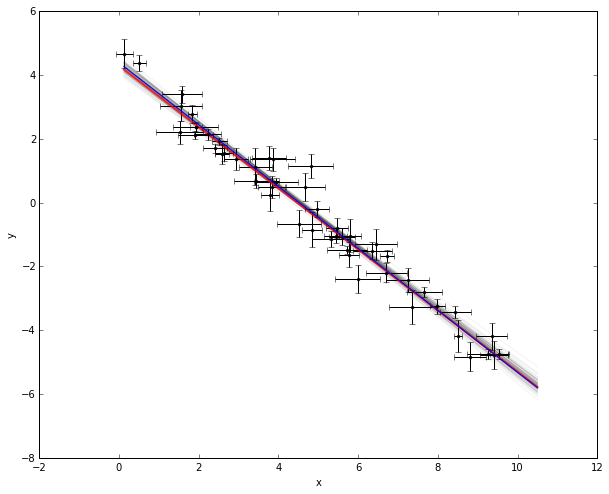

In [19]:
xl = np.array([min(x)*.9, max(x)*1.1])
for m, b in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.05)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")
plt.plot(xl,slope*xl+intercept,'-b') # the linear regression fit result.
plt.xlabel('x')
plt.ylabel('y')

<h1> Now find the 1 sigma bounds of the MCMC, from 16 to 84 percentile <br/> then compare the results </h1>

In [20]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [21]:
[m_mcmc, b_mcmc] # these are the results of the MCMC with +/- 1 sigma 

[(-0.95868906785835573, 0.022562755824237057, 0.022571129446219307),
 (4.3504466908609158, 0.11636322337320681, 0.11545415823081395)]

<h3> This was the reult of Chi^2 fitting... OK, but not so great </h3>

In [22]:
[m_guess, b_guess]

[-0.97082290275925809, 4.3923459420335647]

<h3> These was the true values we started with...  </h3>

In [23]:
[m_true, b_true]

[-0.9594, 4.294]